In [92]:
from src.ETL import *

In [93]:
RESULTS_DIR='../results'

### Small background
To start, the appropriate file has to be downloaded from kaggle. The kaggle dataset can be found [here](https://www.kaggle.com/neha1703/movie-genre-from-its-poster). Downloading directly will result in a zip file that needs to be extracted and get the csv.

### BASIC EDA STATS
These stats were extracted based on code [from this medium article](https://towardsdatascience.com/movie-posters-81af5707e69a) and can be found on this linked [github](https://github.com/timo-boehm/material_blog_posts/blob/master/collect_movie_posters.ipynb). The small snippet below reads in the dataset and shows a dataframe for action movies and romance movies.

In [94]:
movie_data = read_and_clean_data(path="data/MovieGenre.csv")
movie_data = add_year_variable(movie_data)
movie_data = create_boolean_genres(movie_data)
action_movies = extract_genre_data(movie_data, "Action")
action_movies = select_years(action_movies, 1970, 2018)
action_sample = sample_same_number_per_decade(action_movies, use_test_sample=False)

Shape of the original dataset: (40108, 3)
Shape after dropping rows with missing values: (39263, 3)
Shape after dropping rows with potentially misleading poster link: (37850, 3)

There are movies between 1874 and 2018 available in the dataset.

There are 28 genres in the dataset: {'Romance', 'War', 'Music', 'Action', 'Western', 'History', 'News', 'Short', 'Adventure', 'Talk-Show', 'Comedy', 'Biography', 'Documentary', 'Fantasy', 'Sci-Fi', 'Drama', 'Game-Show', 'Mystery', 'Animation', 'Thriller', 'Adult', 'Reality-TV', 'Family', 'Film-Noir', 'Horror', 'Musical', 'Crime', 'Sport'}

Action movies in the dataset: 5133

Movies left between 1970 and 2018: 4614
Movies per decade in the dataset:
10s    1381
00s    1327
90s     855
80s     582
70s     469
Name: decade, dtype: int64

Sample includes 469 movies per decade


In [95]:
romance_movies = extract_genre_data(movie_data, "Romance")
romance_movies = select_years(romance_movies, 1970, 2018)
romance_sample = sample_same_number_per_decade(romance_movies, use_test_sample=False)

Romance movies in the dataset: 5932

Movies left between 1970 and 2018: 4381
Movies per decade in the dataset:
00s    1562
10s    1184
90s     935
80s     440
70s     260
Name: decade, dtype: int64

Sample includes 260 movies per decade


### Downloading the images

Code from the medium article splits up the dataset into training and test sets. This snippet below a train and test directory and then makes multiple directories in each based on decade and downloads the images. Again this is only for the sample on action movies.

In [5]:
# image_folder = "movie_posters"
# dfs = create_train_and_test_dfs(action_sample)
# create_folder_structure(image_folder, dfs.keys(), set(action_sample.decade))
# download_posters(dfs)
# delete_black_and_white_posters(image_folder)

This snippet below will download the entire dataset without seperating into training and test sets.

In [6]:
# image_folder = "action_posters"
# create_all_folders(image_folder=image_folder, classes = set(action_sample.decade))
# download_all(action_sample, image_folder=image_folder)

In [7]:
# image_folder = "romance_posters"
# create_all_folders(image_folder=image_folder, classes = set(romance_sample.decade))
# download_all(romance_sample, image_folder=image_folder)

### Movie Genre Statistics

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
sns.set(color_codes=True)


Bad key "text.kerning_factor" on line 4 in
//anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


#### Distribution of Movies Over Each Decade

In [96]:
# get counts per year
years = pd.DataFrame(movie_data.groupby('year').size()).reset_index()
years.columns=['year', 'count']
years=years.loc[years.year>=1970]

# relabel by decade
years['decade']=years.year.apply(lambda x: (x//10)*10)

# get counts of decade
decades = pd.DataFrame(years.groupby('decade')['count'].sum()).reset_index()

# read decade as integer
decades.decade = decades.decade.apply(lambda x: int(x))
decades.columns=['decade', 'count']

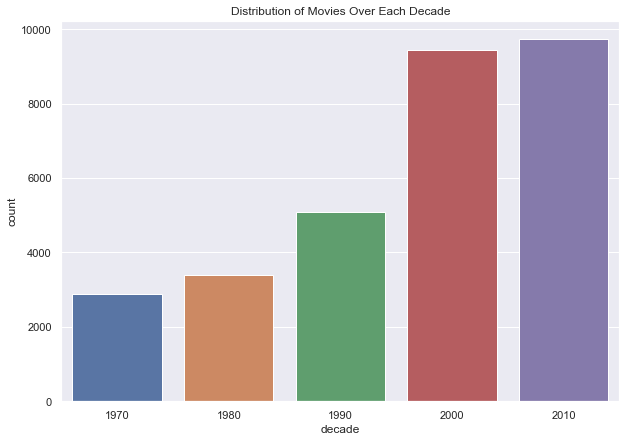

In [105]:
#plot
plt.figure(figsize=(10,7))
fig1 = (
    sns.barplot(x='decade', y='count', data=decades)
    .set_title('Distribution of Movies Over Each Decade')
)
plt.savefig('results/dist_of_movies_over_each_decade.jpg');

#### Distribution of Movie Genres

In [11]:
# df with the one-hot genres
genres_ohe=movie_data.drop(columns=['Title', 'Poster', 'year'])

In [12]:
genres = genres_ohe.sum()
genres = genres.sort_values(ascending=False)[:10]

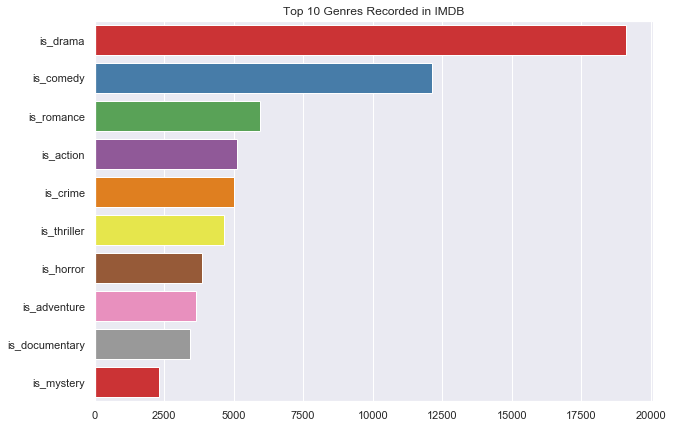

In [106]:
plt.figure(figsize=(10,7))
fig2 = sns.barplot(genres.values, genres.index, palette='Set1')
fig2.set_title('Top 10 Genres Recorded in IMDB');
plt.savefig('results/top_ten_genres.jpg');

In [14]:
movie_data['decade']=movie_data.year.apply(lambda x: (x//10)*10)

In [15]:
genre_dec=movie_data.groupby('decade').sum().reset_index().drop(columns=['year'])
genre_dec=genre_dec.loc[genre_dec.decade>=1970]
genre_dec=genre_dec.groupby('decade').sum()[['is_action', 'is_romance']]
genre_dec.index = pd.Series(genre_dec.index).apply(lambda x: str(int(x)))
genre_dec = genre_dec.reset_index()

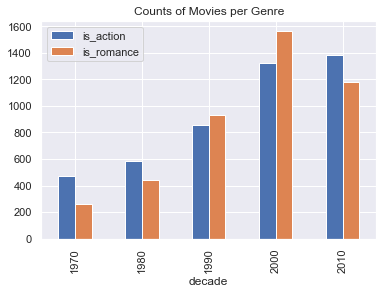

In [107]:
genre_dec.set_index('decade').plot(kind='bar').set_title('Counts of Movies per Genre');
plt.savefig('results/counts_of_movies_per_genre.jpg');

### Extracting Movie Poster Image Features

In [17]:
import cv2

In [18]:
import os
import pandas as pd
from IPython.display import Image, display
import glob
import numpy as np
from skimage import io

In [19]:
# import the necessary packages
from imutils import build_montages
from imutils import paths
import numpy as np
import argparse
import imutils
import cv2

#### Colorfulness

In [20]:
def image_colorfulness(image):
	# split the image into its respective RGB components
	(B, G, R) = cv2.split(image.astype("float"))
	# compute rg = R - G
	rg = np.absolute(R - G)
	# compute yb = 0.5 * (R + G) - B
	yb = np.absolute(0.5 * (R + G) - B)
	# compute the mean and standard deviation of both `rg` and `yb`
	(rbMean, rbStd) = (np.mean(rg), np.std(rg))
	(ybMean, ybStd) = (np.mean(yb), np.std(yb))
	# combine the mean and standard deviations
	stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
	meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))
	# derive the "colorfulness" metric and return it
	return stdRoot + (0.3 * meanRoot)

#### Corners

In [21]:
FOLD_DIR = 'action_posters/all'
decades = ['00s', '10s', '70s', '80s', '90s']

In [22]:
def image_dir_decade(decade):
    return f'{FOLD_DIR}/{decade}'

In [23]:
image_dir_decade('00s')

'action_posters/all/00s'

In [24]:
if not os.path.exists(image_dir_decade('00s')):
    print('fail')

In [25]:
action_list=[]
count=0
for decade in decades:
    decade_path = image_dir_decade(decade)
    for imagePath in glob.glob('{}/*.jpg'.format(decade_path)): #assuming JPG
        filename=imagePath.split('/')[-1]
        filepath = decade_path + '/' + filename
        action_list.append(filepath)
    #     df_list.append(calc_stats(filename))
        count+=1
    #     print("Uploaded {}".format(count) + filename)

In [26]:
action_list[0]

'action_posters/all/00s/1000095.jpg'

In [27]:
# corners_list = []
# colorfulness_list = []
# for i in range(len(action_list)):
#     image_path = action_list[i]
#     img = cv2.imread(image_path)
#     # calculating colorfulness
#     colorfulness = image_colorfulness(img)
#     colorfulness_list.append(colorfulness)
#     gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#     # find Harris corners
#     gray = np.float32(gray)
#     dst = cv2.cornerHarris(gray,2,3,0.04)
#     dst = cv2.dilate(dst,None)
#     ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
#     dst = np.uint8(dst)
#     # find centroids
#     ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
#     # define the criteria to stop and refine the corners
#     criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
#     corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
#     corners_list.append(len(corners))

In [125]:
# action_feat=pd.DataFrame({'img':action_list, 'num_corners': corners_list, 'colorfulness': colorfulness_list})
# action_feat['imdbId']=action_feat.img.apply(lambda x: int(x.split('/')[-1].split('.')[0]))
# action_feat=action_feat.merge(action_sample, on='imdbId')

In [126]:
# action_feat.to_csv('data/action_feat.csv', index=False)

In [28]:
action_feat = pd.read_csv('data/action_feat.csv')

In [29]:
action_feat.groupby('decade')['num_corners'].mean()

decade
00s    107.737805
10s    112.684848
70s    112.117512
80s    105.770149
90s    105.743697
Name: num_corners, dtype: float64

In [30]:
action_feat.groupby('decade')['colorfulness'].mean()

decade
00s    54.022886
10s    44.989328
70s    60.299711
80s    59.198335
90s    64.167229
Name: colorfulness, dtype: float64

#### Romance

In [31]:
FOLD_DIR = 'romance_posters/all'
decades = ['00s', '10s', '70s', '80s', '90s']

In [32]:
def image_dir_decade(decade):
    return f'{FOLD_DIR}/{decade}'

In [33]:
image_dir_decade('00s')

'romance_posters/all/00s'

In [34]:
romance_list=[]
count=0
for decade in decades:
    decade_path = image_dir_decade(decade)
    for imagePath in glob.glob('{}/*.jpg'.format(decade_path)): #assuming JPG
        filename=imagePath.split('/')[-1]
        filepath = decade_path + '/' + filename
        romance_list.append(filepath)
    #     df_list.append(calc_stats(filename))
        count+=1
    #     print("Uploaded {}".format(count) + filename)

In [35]:
romance_list[0]

'romance_posters/all/00s/1022603.jpg'

In [130]:
# corners_list = []
# colorfulness_list = []
# for i in range(len(romance_list)):
#     image_path = romance_list[i]
#     img = cv2.imread(image_path)
#     # calculating colorfulness
#     colorfulness = image_colorfulness(img)
#     colorfulness_list.append(colorfulness)
#     gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#     # find Harris corners
#     gray = np.float32(gray)
#     dst = cv2.cornerHarris(gray,2,3,0.04)
#     dst = cv2.dilate(dst,None)
#     ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
#     dst = np.uint8(dst)
#     # find centroids
#     ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
#     # define the criteria to stop and refine the corners
#     criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
#     corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
#     corners_list.append(len(corners))

In [131]:
# romance_feat=pd.DataFrame({'img':romance_list, 'num_corners': corners_list, 'colorfulness': colorfulness_list})
# romance_feat['imdbId']=romance_feat.img.apply(lambda x: int(x.split('/')[-1].split('.')[0]))
# romance_feat=romance_feat.merge(romance_sample, on='imdbId')

In [134]:
# romance_feat.to_csv('data/romance_feat.csv', index=False)

In [36]:
romance_feat = pd.read_csv('data/romance_feat.csv')

In [37]:
romance_feat.groupby('decade')['num_corners'].mean()

decade
00s     99.666667
10s     96.857143
70s     97.134454
80s     98.510638
90s    100.785714
Name: num_corners, dtype: float64

In [38]:
romance_feat.groupby('decade')['colorfulness'].mean()

decade
00s    52.165209
10s    52.128693
70s    52.318652
80s    51.334527
90s    59.706520
Name: colorfulness, dtype: float64

### Visualize Features

In [39]:
decade_order = ['70s', '80s', '90s', '00s', '10s']

In [40]:
grouped_corners = pd.DataFrame(action_feat.groupby('decade')['num_corners'].mean().loc[decade_order]).loc[decade_order]#.reset_index()
grouped_corners.columns = ['action_corners']
grouped_corners['romance_corners'] = romance_feat.groupby('decade')['num_corners'].mean().loc[decade_order].loc[decade_order].values

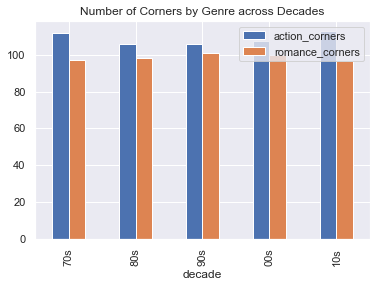

In [109]:
grouped_corners.plot(kind='bar')
plt.title('Number of Corners by Genre across Decades');
plt.savefig('results/corners.jpg');

In [42]:
grouped_color = pd.DataFrame(action_feat.groupby('decade')['colorfulness'].mean().loc[decade_order]).loc[decade_order]#.reset_index()
grouped_color.columns = ['action_colorfulness']
grouped_color['romance_colorfulness'] = romance_feat.groupby('decade')['colorfulness'].mean().loc[decade_order].loc[decade_order].values

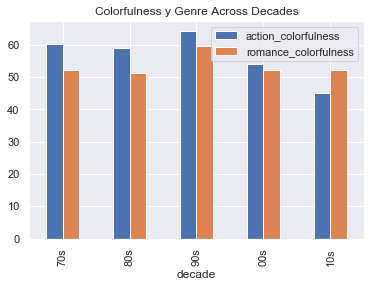

In [110]:
grouped_color.plot(kind='bar')
plt.title('Colorfulness y Genre Across Decades');
plt.savefig('results/colorfulness.jpg');

## Corner Demonstration

In [112]:
    image_path = action_list[0]
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # find Harris corners
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray,2,3,0.04)
    dst = cv2.dilate(dst,None)
    ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
    dst = np.uint8(dst)
    # find centroids
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
    # define the criteria to stop and refine the corners
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

In [113]:
# Now draw them
res = np.hstack((centroids,corners))
res = np.int0(res)
img[res[:,1],res[:,0]]=[0,0,255]
img[res[:,3],res[:,2]] = [0,255,0]

In [114]:
img[dst>0.01*dst.max()]=[0,0,255]

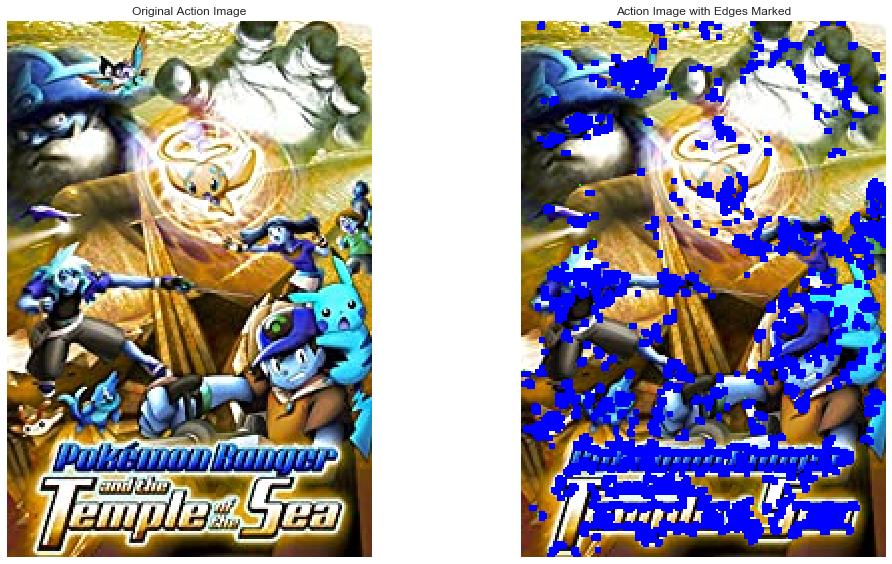

In [115]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 8))

ax0.imshow(cv2.imread(image_path))
ax0.set_title("Original Action Image")
ax0.axis('off')
ax1.imshow(img)
ax1.set_title("Action Image with Edges Marked")
ax1.axis('off')

fig.tight_layout()

plt.savefig('results/action_corners.jpg');

In [88]:
len(corners)

164

In [117]:
    image_path = romance_list[-1]
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # find Harris corners
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray,2,3,0.04)
    dst = cv2.dilate(dst,None)
    ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
    dst = np.uint8(dst)
    # find centroids
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
    # define the criteria to stop and refine the corners
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

In [118]:
# Now draw them
res = np.hstack((centroids,corners))
res = np.int0(res)
img[res[:,1],res[:,0]]=[0,0,255]
img[res[:,3],res[:,2]] = [0,255,0]

In [119]:
img[dst>0.01*dst.max()]=[0,0,255]

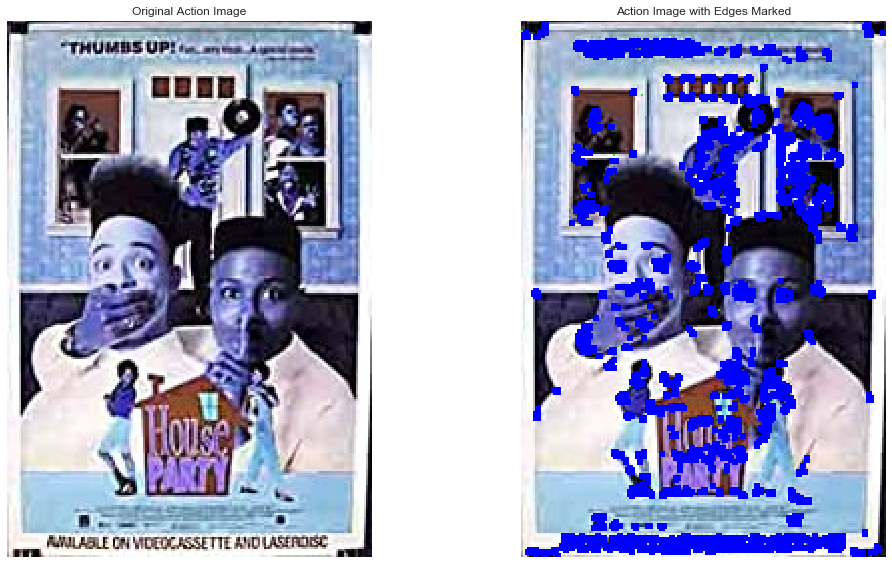

In [120]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 8))

ax0.imshow(cv2.imread(image_path))
ax0.set_title("Original Action Image")
ax0.axis('off')
ax1.imshow(img)
ax1.set_title("Action Image with Edges Marked")
ax1.axis('off')

fig.tight_layout()

plt.savefig('results/romance_corners.jpg');

In [93]:
len(corners)

127

## Colorfulness Demonstration

In [71]:
def get_list(df):
    ret = []
    for index, row in df.iterrows():
        image_path = row[0]
        C = row[1]
        image = cv2.imread(image_path)
        cv2.putText(image, "{:.2f}".format(C), (40, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.4, (0, 255, 0), 3)
        ret.append((image, C))
    return ret

In [73]:
top_9_action = action_feat[['img', 'colorfulness']].sort_values(by='colorfulness', ascending=False)[:9]
top_9_action_list = get_list(top_9_action)
mostColor_action = [r[0] for r in top_9_action_list[:25]]
mostColorMontage_action = build_montages(mostColor_action, (128, 128), (3, 3))

In [77]:
bottom_9_action = action_feat[['img', 'colorfulness']].sort_values(by='colorfulness', ascending=False)[-9:]
bottom_9_action_list = get_list(bottom_9_action)
leastColor_action = [r[0] for r in bottom_9_action_list[:25]]
leastColorMontage_action = build_montages(leastColor_action, (128, 128), (3, 3))

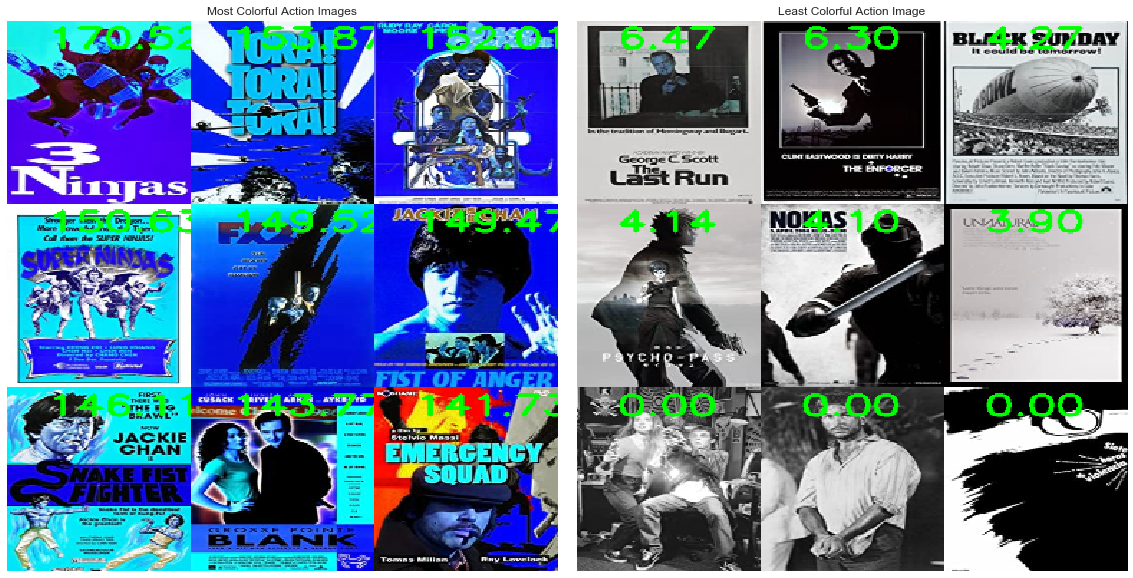

In [121]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 8))

ax0.imshow(mostColorMontage_action[0])
ax0.set_title("Most Colorful Action Images")
ax0.axis('off')
ax1.imshow(leastColorMontage_action[0])
ax1.set_title("Least Colorful Action Image")
ax1.axis('off')

fig.tight_layout()

plt.savefig('results/action_colorfulness.jpg');

In [81]:
top_9_romance = romance_feat[['img', 'colorfulness']].sort_values(by='colorfulness', ascending=False)[:9]
top_9_romance_list = get_list(top_9_romance)
mostColor_romance = [r[0] for r in top_9_romance_list[:25]]
mostColorMontage_romance = build_montages(mostColor_romance, (128, 128), (3, 3))

In [82]:
bottom_9_romance = romance_feat[['img', 'colorfulness']].sort_values(by='colorfulness', ascending=False)[-9:]
bottom_9_romance_list = get_list(bottom_9_romance)
leastColor_romance = [r[0] for r in bottom_9_romance_list[:25]]
leastColorMontage_romance = build_montages(leastColor_romance, (128, 128), (3, 3))

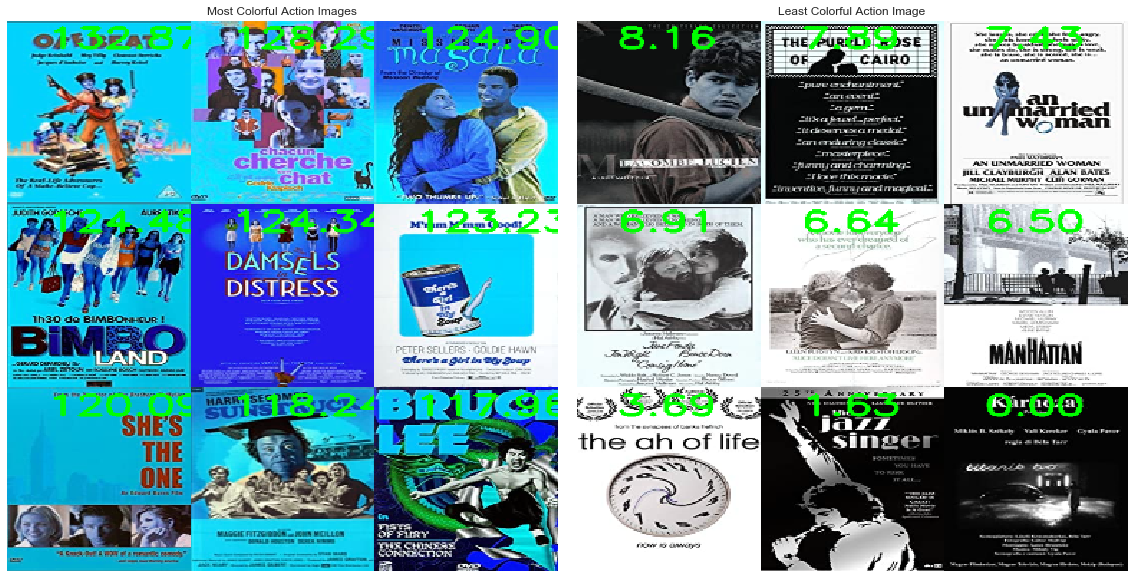

In [122]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 8))

ax0.imshow(mostColorMontage_romance[0])
ax0.set_title("Most Colorful Action Images")
ax0.axis('off')
ax1.imshow(leastColorMontage_romance[0])
ax1.set_title("Least Colorful Action Image")
ax1.axis('off')

fig.tight_layout()

plt.savefig('results/romance_colorfulness.jpg');